In [ ]:
pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 29.0 MB/s eta 0:00:00


In [ ]:
import pulp as lp
import pandas as pd

# Load data
advertiser_data = pd.DataFrame({
    'Month': ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06',
              '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12'],
    'Advertisers': [1024, 996, 1024, 972, 943, 859, 915, 919, 1063, 1499, 1478, 1369],
    'Avg_Budget': [84301, 86866, 86477, 86291, 86199, 84493, 86704, 84993, 87440, 86020, 85232, 86105]
})

# Parameters
initial_agents = 652
annual_salary = 77721
monthly_salary = annual_salary / 12
firing_cost_perc = 0.4
max_adv_per_agent = 10
expected_uplift = 0.135
n_months = len(advertiser_data)

# Initialize PuLP problem
prob = lp.LpProblem("Dynamic_Staffing_Optimization", lp.LpMinimize)

# Decision Variables
months = list(range(n_months))
A = lp.LpVariable.dicts("Available_Agents", months, lowBound=0, cat='Integer')  # Available agents at start of month
N = lp.LpVariable.dicts("New_Hires", months, lowBound=0, cat='Integer')         # New hires in month
F = lp.LpVariable.dicts("Fired", months, lowBound=0, cat='Integer')             # Fired agents in month
S = lp.LpVariable.dicts("Assigned_Advertisers", months, lowBound=0, cat='Integer')  # Advertisers assigned
W = lp.LpVariable.dicts("Waiting_Pool", months, lowBound=0, cat='Integer')       # Advertisers waiting
D = lp.LpVariable.dicts("Dropped_Advertisers", months, lowBound=0, cat='Integer')  # Advertisers dropped after 60 days
G = lp.LpVariable.dicts("Graduated_Advertisers", months, lowBound=0, cat='Integer')  # Advertisers graduated after 60 days
T = lp.LpVariable.dicts("Total_Agents", months, lowBound=0, cat='Integer')  # Total Agents in month (need to pay)

In [ ]:
# Initial Conditions
prob += A[0] == initial_agents  # Starting agents
W_prev = 0  # Initial waiting pool
S_prev = 0  # Initial assigned advertisers

# Constraints
for m in months:

    # 1. Waiting Pool: W[m] = W_prev + new advertisers - assigned - dropped
    prob += W[m] == W_prev + advertiser_data['Advertisers'][m] - S[m] - D[m]
    prob += W[m] >= 0

    # 2. Dropped Advertisers: Those waiting for more than 60 days
    if m >= 2:
        prob += D[m] == W[m-2]  # Drop advertisers who have been waiting for 2 months
    else:
        prob += D[m] == 0  # No one is dropped in the first two months

    # 3. Graduated Advertisers: Advertisers exit after 60 days of support
    if m >= 2:
        prob += G[m] == S[m-2]  # Graduates advertisers assigned two months ago
    else:
        prob += G[m] == 0  # No one graduates in the first two months

    # 4. Hiring/Firing Constraints
    prob += N[m] <= A[m]
    prob += F[m] <= A[m]

    # 5. Required Agents: A[m] * 10 >= S[m] + S_prev (eliminates division)
    prob += A[m] * 10 >= S[m] + S_prev  # Ensures sufficient capacity for current and past advertisers

    # Update next month's available agents
    if m < n_months - 1:
        prob += A[m+1] == A[m] + N[m] - F[m]

    # Update variables for next iteration
    W_prev = W[m]
    S_prev = S[m]

    # Update Total Agents (Can support advertisers + cannot support advertisers)
    if m == 0:
      prob += T[m] == A[m] + N[m]
    else:
      prob += T[m] == T[m-1] + N[m] - F[m-1]

# Objective Function (Minimize Costs + Waiting Time Penalty)
total_cost = lp.lpSum(
    [A[m] * monthly_salary + F[m] * firing_cost_perc * annual_salary
     - S[m] * advertiser_data['Avg_Budget'][m] * expected_uplift
     + W[m] * (advertiser_data['Avg_Budget'][m] / 12 * expected_uplift)  # Waiting penalty
     for m in months]
)
prob += total_cost

# Solve
prob.solve()

1

In [ ]:
# Results
results = []
for m in months:
    results.append({
        'Month': advertiser_data['Month'][m],
        'Available Agents': A[m].varValue,
        'New Hires': N[m].varValue,
        'Fired': F[m].varValue,
        'Total Agents':T[m].varValue,
        'Assigned Advertisers': S[m].varValue,
        'Waiting Advertisers': W[m].varValue,
        'Dropped Advertisers': D[m].varValue,
        'Graduated Advertisers': G[m].varValue,
        'Total Cost ($)': round(T[m].varValue * monthly_salary + F[m].varValue * firing_cost_perc * annual_salary, 2),
        'Revenue Uplift ($)': round(S[m].varValue * advertiser_data['Avg_Budget'][m] * expected_uplift, 2),
        'Waiting Cost Penalty ($)': round(W[m].varValue * (advertiser_data['Avg_Budget'][m] / 12 * expected_uplift), 2)
    })

results_df = pd.DataFrame(results)
total_annual_cost = results_df['Total Cost ($)'].sum()
total_uplift = results_df['Revenue Uplift ($)'].sum()
net_profit = total_uplift - total_annual_cost

print(results_df.to_string(index=False))
print(f"\nTotal Annual Cost: ${total_annual_cost:,.2f}")
print(f"Total Revenue Uplift: ${total_uplift:,.2f}")
print(f"Net Profit: ${net_profit:,.2f}")

  Month  Available Agents  New Hires  Fired  Total Agents  Assigned Advertisers  Waiting Advertisers  Dropped Advertisers  Graduated Advertisers  Total Cost ($)  Revenue Uplift ($)  Waiting Cost Penalty ($)
2025-01             652.0        0.0  450.0         652.0                1024.0                  0.0                  0.0                    0.0     18212621.00         11653770.24                      0.00
2025-02             202.0        0.0    0.0         202.0                 996.0                  0.0                  0.0                    0.0      1308303.50         11680002.36                      0.00
2025-03             202.0        0.0    2.0         202.0                1024.0                  0.0                  0.0                 1024.0      1370480.30         11954580.48                      0.00
2025-04             200.0        0.0    1.0         200.0                 972.0                  0.0                  0.0                  996.0      1326438.40         113

<ipython-input-34-28756ecc6dff>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=results_df, x='Month', y='Net Profit ($)', marker='o', palette='#00296B')
<ipython-input-34-28756ecc6dff>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Scenario')


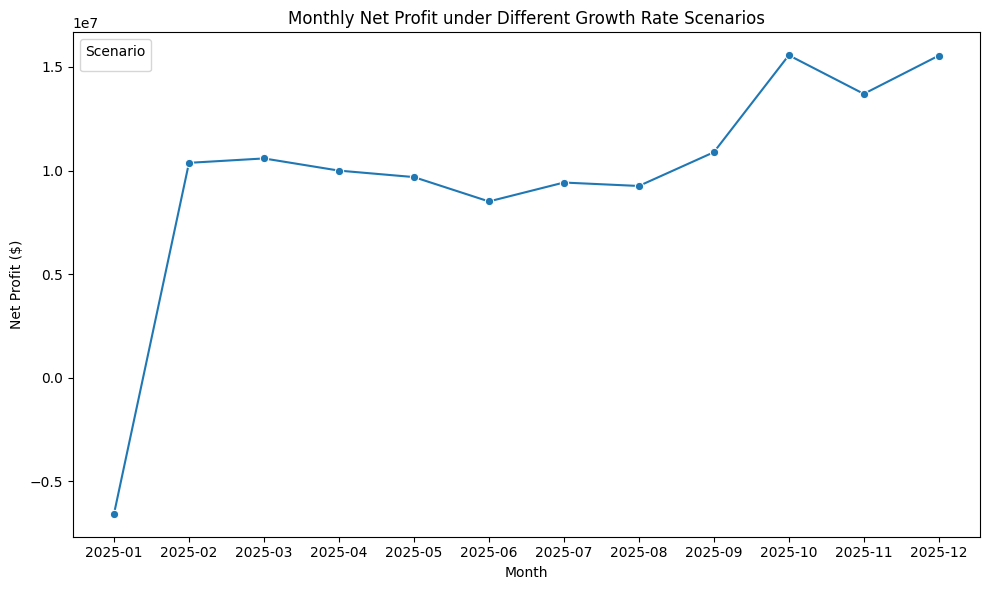

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df['Net Profit ($)'] = results_df['Revenue Uplift ($)'] - results_df['Total Cost ($)']


# Net Profit Trend by Scenario
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Month', y='Net Profit ($)', marker='o', palette='#00296B')
plt.title('Monthly Net Profit under Different Growth Rate Scenarios')
plt.xlabel('Month')
plt.ylabel('Net Profit ($)')
plt.grid(False)
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()